Case 2b: Nickel strip with circular cut profile but with center of circles out of the strips

With the center of the circle not constrained to be within the strips, this opens up an extra dimension of solutions to us, albeit having it come with an extra variable to tune. The profile is as such:

![](IMG_0746.jpg)
![](IMG_0747.jpg)

Import necessary libraries:

In [3]:
import numpy as np
from numpy import exp, mean
from math import pi, sqrt, asin
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

Define constants

In [4]:
I = 50.0            # current passing through the strip [A]
rho_d = 8890.0e-9   # density of nickel [kg/mm^3]
rho_r = 0.096e-3    # electrical resistivity of nickel [Ohm*mm]
dt = 1.0            # elapsed time [s]
h = 0.2             # nickel strip thickness [mm]
w0 = 8              # nickel strip default width [mm]
cp = 465            # sp. heat capacity of nickel [J/kgK]
Tm = 1435           # melting point temperature of nickel [C]
Tamb = 20           # ambient temperature [C]
Lf = 293e3          # sp. latent heat of nickel [J/kg]

With the local and global axes placed differently, we will have to adjust our original circle equation:

$$X^2 + Y^2 = r^2$$
$$X = x, Y = y + d$$
$$\therefore x^2 + (y + d)^2 = r^2$$
$$y(x,r,d) = \sqrt{r^2 - x^2} - d,\hspace{1cm} x \in \left[-\sqrt{r^2 - d^2}, \sqrt{r^2 - d^2}\right]$$
<br>

$$f(x,r,d) = w_0 - 2y = w_0 + 2d - 2\sqrt{r^2 - x^2},\hspace{1cm} x \in \left[-\sqrt{r^2 - d^2}, \sqrt{r^2 - d^2}\right]$$ 

Where $y$ is the height of the segment of the circle on the strip. At the end of the day, we solve for $d$ for each cases of $r$. From the above equation, it is easily seen that the maximum segment height, $y_m$, is equal to:

$$y_m = y(0,r,d) = r - d$$

Furthermore, $d$ have to respect these bounds:

$$2y_m < w_0$$
$$2(r - d) < w_0$$
$$d > \frac{2r - w_0}{2}$$ 
<br>

$$r^2 - d^2 > 0$$
$$d < r$$ 
<br>

$$\therefore d \in \left(\frac{2r - w_0}{2}, r\right)





In [5]:
# define functions f(x,r,d) and g(x,r,d)

def f(x,r,d): 
    if (r**2 - x**2) < 1e-15:
        return w0 + 2*d
    else: return w0 + 2*d - 2*sqrt(r**2 - x**2)

def g(x,r,d): return 1/f(x,r,d)

In [6]:
# define functions of lower bound and upper bounds, x0(r,d) and xf(r,d)

def xf(r,d):
    if (r**2 - d**2) < 1e-15:
        return 0
    else: return sqrt(r**2 - d**2)

def x0(r,d): return -xf(r,d)

As with case 2a, we define:

$$\int_{x_0}^{x_f}{g(x,r,d) dx} \approx G_n(r,d) =  \frac{x_f - x_0}{3}\left(g(x_0,r,d)+g(x_f,r,d)+2\sum_{i = 1}^{n-2}g(x_{2i},r,d)+4\sum_{i = 1}^{n-1}g(x_{2i-1},r,d)\right)$$

In [7]:
# define simpsons rule to carry out numerical integration
# size MUST be an odd number
# **vars are all additional arguments needed to evaluate the passed function

def simpsons(function,size,lower_bound,upper_bound, **vars):
    delta_x = (upper_bound - lower_bound)/(size - 1)
    x = np.linspace(lower_bound,upper_bound,size)
    points = np.array([function(x[i], **vars) for i in range(len(x))])

    result = (delta_x/3)*(points[0] + points[-1] + 2*sum(points[2:size - 2:2]) + 4*sum(points[1:size - 1:2]))
    return result

In [8]:
a = 0
b = pi
n = 11
x = np.linspace(a,b,n)
def k(x,r): return np.sin(x*r)

I_simp = simpsons(k,n,a,b, r = 2)
print(I_simp)


4.4108427377215436e-17


To define the volume, we setup our geometry as such:

![](IMG_0748.jpg)

We can find out the angle $\theta$ using the identity:
$$\sin{\theta} = \frac{x_f}{r}$$
$$\therefore \theta = \arcsin\left({\frac{\sqrt{r^2 - d^2}}{r}}\right)$$

So, the area of the segment is:
$$A = 2\left(\frac{r^2}{2}\arcsin{\left(\frac{\sqrt{r^2 - d^2}}{r}\right)} - \frac{d}{2}\sqrt{r^2 - d^2}\right) = r^2\arcsin{\left(\frac{\sqrt{r^2 - d^2}}{r}\right)} - d\sqrt{r^2 - d^2}$$

The volume is then:
$$V(r,d) = hA_{\text{face}} = h(w_0l - 2A) = 2(w_0h + d)\sqrt{r^2 - d^2} - 2r^2h\arcsin{\left(\frac{\sqrt{r^2 - d^2}}{r}\right)}$$

For convenience, as done in case 2a, we leave the $h$ out of the volume function and lump it with the other constants. Redefine:

$$V(r,d) = A_{\text{face}} = (w_0l - 2A) = 2(w_0 + d)\sqrt{r^2 - d^2} - 2r^2\arcsin{\left(\frac{\sqrt{r^2 - d^2}}{r}\right)}$$
$$K = \frac{\rho_dh^2}{I^2\rho_r\Delta{t}}\left(c_p\left(T_m - T_\infty\right) + L_f\right)$$

Let:

$$\frac{G_n(r,d)}{V(r,d)} - K= H_n(r,d)$$

In [9]:
# import integrated functions of cp and rho_r
from rho_r_vs_T import int_rho_r
from cp_vs_T import int_cp

In [10]:
T_lower = Tamb + 273.15
T_upper = Tm + 273.15

In [12]:
# define function of volume, V(r,d)
def V(r,d): return 2*(w0 + d)*sqrt(r**2 - d**2) - 2*r**2*asin(sqrt(r**2 - d**2)/r)

# the lumped constant
K = rho_d*h**2*(int_cp(T_lower,T_upper) + Lf)/(I**2*int_rho_r(T_lower,T_upper)*dt)

# define lumped function H(r,d)
def H(function,size,lower_bound,upper_bound, **vars): return simpsons(function,size,lower_bound,upper_bound, **vars)/V(**vars) - K

# define the first derivative of H wrt d, H_prime(r,d):
def H_prime(lower_limit,upper_limit,size_h,point, **vars):
    delta_x = (upper_limit - lower_limit)/(size_h - 1) 
    return (H(d = point + delta_x, **vars) - H(d = point - delta_x, **vars))/(2*delta_x)
    
    

In [13]:
# define the upper and lower limits for d, ul(r) and ll(r)

def ll(r): return (2*r - w0)/2
def ul(r): return r

Finding the exact bounds for $r$ is challenging, but a conservative bound would follow:
$$2y_m < w_0$$
$$\therefore r \geq \frac{1}{2}w_0

We now run a convergence algorithm for finding $d$:

In [34]:
# list of R to be tested
step = 1
R = np.arange(1/2*w0,100+step,step)
D = np.zeros(len(R))

# convergence algorithm using Newton-Raphson method, but modified a tiny bit
eps = 1e-6
size_x = 1001            # divide x into 101 points with equal space in between
size_h = 5000           # divide d (for H prime) into 5000 points
alpha = 1e-3

for i in range(len(R)):
    print(f"R = {R[i]}")

    error = 1

    upper_limit = ul(R[i])
    lower_limit = ll(R[i])

    d = lower_limit + 0.01

    while abs(error) > eps:
        print(f"d = {d}")

        error = H(g,size_x,x0(R[i],d), xf(R[i],d), r = R[i], d = d)
        # slope = H_prime(lower_limit,upper_limit,size_h,d, function = g, size = size_x, lower_bound = x0(R[i],d), upper_bound = xf(R[i],d), r = R[i])
        # gamma = alpha/slope*error

        print(f"error = {error}")
        # print(f"slope = {slope}")

        # only let step size get smaller, not bigger
        if 1/abs(slope) > 1:
            gamma = alpha*error

        d = d - gamma
        
    # print(f"d = {d}")
    D[i] = d




R = 4.0
d = 0.01
error = 2.725976165099641
slope = -163.707047863042
d = 0.010016651550441373
error = 2.7232644118292892
slope = -163.29875271288483
d = 0.010033328128593916
error = 2.720555319491926
slope = -162.89155139589576
d = 0.01005002976410649
error = 2.717848885639508
slope = -162.48544085435753
d = 0.010066756486644516
error = 2.715145107825045
slope = -162.08041803909165
d = 0.010083508325889959
error = 2.7124439836021756
slope = -161.67647990978128
d = 0.010100285311541278
error = 2.7097455105269557
slope = -161.2736234345803
d = 0.010117087473313417
error = 2.707049686157304
slope = -160.8718455914616
d = 0.010133914840937655
error = 2.704356508051413
slope = -160.4711433654883
d = 0.010150767444161725
error = 2.701665973770225
slope = -160.07151375154643
d = 0.010167645312749659
error = 2.6989780808754316
slope = -159.6729537531897
d = 0.010184548476481741
error = 2.6962928269302426
slope = -159.27546038193609
d = 0.010201476965154539
error = 2.6936102094998424
slope = -1

KeyboardInterrupt: 

In [88]:
i = 2
R = np.linspace(4,500)
size = 101
points = []

for i in range(len(R)):
    set_points = []

    lower_limit = ll(R[i])
    upper_limit = ul(R[i])
    D = np.linspace(lower_limit + 0.1,upper_limit - 0.1)
    for j in range(len(D)):
        lower_bound = x0(R[i],D[j])
        upper_bound = xf(R[i],D[j])
        set_points.append(H(g,size,lower_bound,upper_bound, r = R[i], d = D[j]))

    points.append(set_points)
    
points = np.array(points)



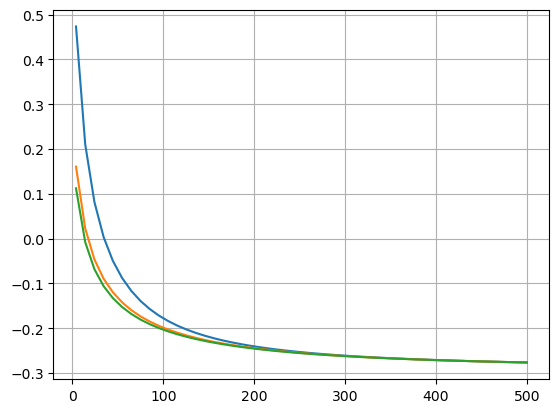

In [90]:
# for i in range(3):
#     plt.plot(D,points[i,:])
plt.plot(R,points[0,:])
plt.plot(R,points[1,:])
plt.plot(R,points[-1,:])
plt.grid(1)
plt.show()

If we plot these outputs, it mysteriously plots a straight line:

In [ ]:
plt.rcParams['text.usetex'] = 1

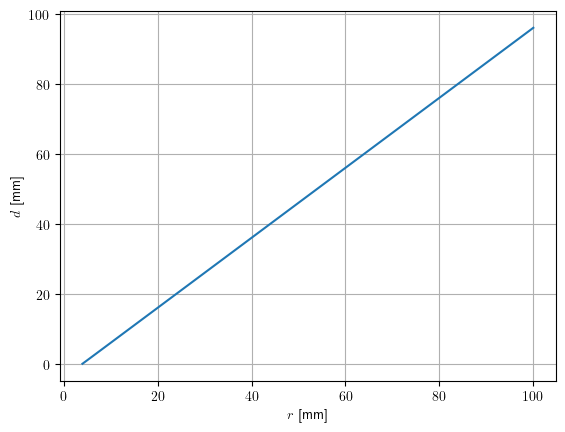

In [ ]:
plt.plot(R,D)
plt.grid(1)
plt.xlabel("$r$ [mm]")
plt.ylabel("$d$ [mm]")
plt.show()

If we run a linear regression through the plots, we obtain:

In [ ]:
R = R.reshape(-1,1)
D = D.reshape(-1,1)

model = LinearRegression()
model.fit(R,D)

D_pred = model.predict(R)

print(f"d = ({model.coef_[0][0]:.3f})R + ({model.intercept_[0]:.3f})")
print(f"R2 score = {model.score(R,D)}")

MSE_lin = mean((D_pred - D)**2)
print(f"MSE = {MSE_lin}")

d = (1.000)R + (-3.985)
R2 score = 0.9999999884673357
MSE = 9.04044861909952e-06


Well, _almost_ linear. But even if it seems like the model has an incredibly high accuracy, the solution is pretty off from the real one for $R < 8$ mm:

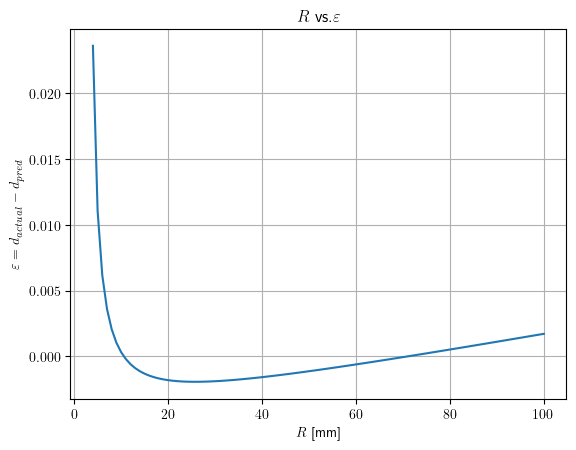

In [ ]:
diff = D - D_pred
plt.plot(R,diff)
plt.title("$R$ vs.$\\varepsilon$")
plt.xlabel("$R$ [mm]")
plt.ylabel("$\\varepsilon = d_{actual} - d_{pred}$")
plt.grid(1)
plt.show()

The graph below illustrates this better:

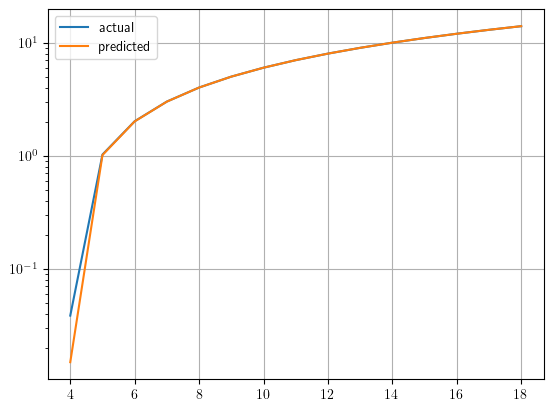

In [ ]:
plt.plot(R[0:15],D[0:15])
plt.plot(R[0:15],D_pred[0:15])
plt.grid(1)
plt.legend(["actual", "predicted"])
plt.yscale('log')
plt.show()

Thus, we can conclude that the relationship between the radii of the circle cutouts and the depth of which the center of the circles are away from the edge of the strip is:

$$d(R) = R -3.989mm, \hspace{1cm} R \geq 8mm$$

And so the smallest part of the strip is given by:

$$\text{fuse width} = w_0 - 2y_m = w_0 - 2(r - d) $$

This cancels out $R$ and leaves the fuse width a definite answer:

$$\text{fuse width}  = 0.204 mm,\hspace{1cm} R \geq 8mm$$

Which is a more feasible option than with case 2a, but still a really small width. This design might also not be a comfortable design.